In [189]:
import requests
import pandas as pd

In [190]:
import config

In [191]:
data2019 = requests.get(f'https://api.census.gov/data/2018/abscs?get=NAME,GEO_ID,NAICS2017_LABEL,SEX,ETH_GROUP,RACE_GROUP,VET_GROUP,FIRMPDEMP&for=state:*&NAICS2017=00&key={config.apiKey}').json()

In [192]:
data2020 = requests.get(f'https://api.census.gov/data/2019/abscs?get=NAME,GEO_ID,NAICS2017_LABEL,SEX,ETH_GROUP,RACE_GROUP,VET_GROUP,FIRMPDEMP&for=state:*&NAICS2017=00&key={config.apiKey}').json()

In [193]:
companysummarystate2019 = pd.DataFrame (data2019[1:], columns= data2019[0])

In [194]:
companysummarystate2020 = pd.DataFrame(data2020[1:], columns = data2020[0])

In [195]:
companysummarystate2019.drop(columns = ['GEO_ID','NAICS2017_LABEL','NAICS2017','state'], inplace=True)

In [196]:
companysummarystate2020.drop(columns = ['GEO_ID','NAICS2017_LABEL','NAICS2017','state'], inplace=True)

In [197]:
companysummarystate2019.head()

,NAME,SEX,ETH_GROUP,RACE_GROUP,VET_GROUP,FIRMPDEMP
0,Mississippi,002,029,00,003,0
1,Mississippi,003,029,00,003,466
2,Mississippi,004,029,00,003,572
3,Mississippi,001,001,30,003,926
4,Mississippi,096,096,96,096,37489


In [198]:
companysummarystate2020.head()

,NAME,SEX,ETH_GROUP,RACE_GROUP,VET_GROUP,FIRMPDEMP
0,Mississippi,001,028,00,001,93
1,Mississippi,003,028,00,001,0
2,Mississippi,002,029,50,001,0
3,Mississippi,003,029,50,001,51
4,Mississippi,001,001,60,001,2489


In [199]:
companysummarystate2019.FIRMPDEMP.isna().value_counts()

False    9668
Name: FIRMPDEMP, dtype: int64

In [200]:
companysummarystate2020.FIRMPDEMP.isna().value_counts()

False    9641
Name: FIRMPDEMP, dtype: int64

In [201]:
statemerge = companysummarystate2019.merge(companysummarystate2020, on=['NAME', 'SEX', 'ETH_GROUP', 'RACE_GROUP', 'VET_GROUP'], how='inner', suffixes = ('_2019', '_2020') )

The totals for each column are 001, except Race_Group which is 00.
Make sure that you filter for totals on all the other columns except for the ones you are looking at fo

In [202]:
statemerge

,NAME,SEX,ETH_GROUP,RACE_GROUP,VET_GROUP,FIRMPDEMP_2019,FIRMPDEMP_2020
0,Mississippi,003,029,00,003,466,334
1,Mississippi,004,029,00,003,572,0
2,Mississippi,001,001,30,003,926,801
3,Mississippi,096,096,96,096,37489,37057
4,Mississippi,002,001,00,001,6659,7751
...,...,...,...,...,...,...,...
9133,Minnesota,002,029,00,003,0,0
9134,Minnesota,003,029,00,003,941,1128
9135,Minnesota,004,029,00,003,0,1877
9136,Minnesota,001,001,30,003,0,3025


In [203]:
pd.options.mode.chained_assignment = None

In [204]:
statemerge['FIRMPDEMP_2020'] = pd.to_numeric(statemerge['FIRMPDEMP_2020'])

In [205]:
allownedbus = statemerge.loc[(statemerge['SEX'] == '001') & (statemerge['ETH_GROUP'] == '001') & (statemerge['RACE_GROUP'] == '00') & (statemerge['VET_GROUP'] == '001')]

In [206]:
womenownedbus = statemerge.loc[(statemerge['SEX'] == '002') & (statemerge['ETH_GROUP'] == '001') & (statemerge['RACE_GROUP'] == '00') & (statemerge['VET_GROUP'] == '001')]

In [207]:
womenownedbus = womenownedbus.join(allownedbus.set_index('NAME'), on = 'NAME', lsuffix='_left', rsuffix='_right')

In [208]:
womenownedbus['PERCENTAGE_WOMEN_OWNED'] = womenownedbus['FIRMPDEMP_2020_left']/womenownedbus['FIRMPDEMP_2020_right']

In [209]:
topwomenownedbus = womenownedbus.nlargest(n = 5, columns = 'PERCENTAGE_WOMEN_OWNED')

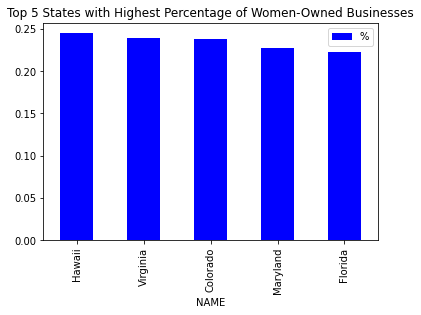

In [210]:
topwomenownedbus.plot(x = 'NAME', y = 'PERCENTAGE_WOMEN_OWNED', kind = 'bar', title = 'Top 5 States with Highest Percentage of Women-Owned Businesses', color = 'blue').legend(['%'])

In [211]:
botwomenownedbus = womenownedbus.nsmallest(n = 5, columns = 'PERCENTAGE_WOMEN_OWNED')

In [212]:
botwomenownedbus = botwomenownedbus.iloc[::-1]

In [213]:
botwomenownedbus

,NAME,SEX_left,ETH_GROUP_left,RACE_GROUP_left,VET_GROUP_left,FIRMPDEMP_2019_left,FIRMPDEMP_2020_left,SEX_right,ETH_GROUP_right,RACE_GROUP_right,VET_GROUP_right,FIRMPDEMP_2019_right,FIRMPDEMP_2020_right,PERCENTAGE_WOMEN_OWNED
968,New Hampshire,002,001,00,001,5274,4742,001,001,00,001,28969,29727,0.159518
7640,Iowa,002,001,00,001,9759,9466,001,001,00,001,60610,59463,0.159191
6879,Idaho,002,001,00,001,6635,6202,001,001,00,001,39080,41098,0.150908
1877,North Dakota,002,001,00,001,0,2849,001,001,00,001,19844,20010,0.142379
3142,South Dakota,002,001,00,001,3194,2958,001,001,00,001,21641,21798,0.135701


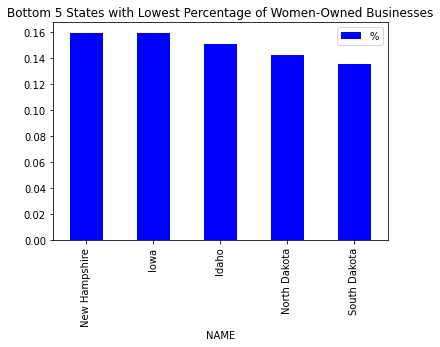

In [214]:
botwomenownedbus.plot(x = 'NAME', y = 'PERCENTAGE_WOMEN_OWNED', kind = 'bar', title = 'Bottom 5 States with Lowest Percentage of Women-Owned Businesses', color = 'blue').legend(['%'])

In [215]:
whiteownedbus = statemerge.loc[(statemerge['SEX'] == '001') & (statemerge['ETH_GROUP'] == '001') & (statemerge['RACE_GROUP'] == '30') & (statemerge['VET_GROUP'] == '001')]

In [216]:
blackownedbus = statemerge.loc[(statemerge['SEX'] == '001') & (statemerge['ETH_GROUP'] == '001') & (statemerge['RACE_GROUP'] == '40') & (statemerge['VET_GROUP'] == '001')]

In [217]:
nativeownedbus = statemerge.loc[(statemerge['SEX'] == '001') & (statemerge['ETH_GROUP'] == '001') & (statemerge['RACE_GROUP'] == '50') & (statemerge['VET_GROUP'] == '001')]

In [218]:
hawaiianownedbus = statemerge.loc[(statemerge['SEX'] == '001') & (statemerge['ETH_GROUP'] == '001') & (statemerge['RACE_GROUP'] == '70') & (statemerge['VET_GROUP'] == '001')]

In [223]:
whiteownedbus['FIRMPDEMP_2019'] = pd.to_numeric(whiteownedbus['FIRMPDEMP_2019'])
whiteownedbus['FIRMPDEMP_2020'] = pd.to_numeric(whiteownedbus['FIRMPDEMP_2020'])

In [224]:
blackownedbus['FIRMPDEMP_2019'] = pd.to_numeric(blackownedbus['FIRMPDEMP_2019'])
blackownedbus['FIRMPDEMP_2020'] = pd.to_numeric(blackownedbus['FIRMPDEMP_2020'])

In [225]:
nativeownedbus['FIRMPDEMP_2019'] = pd.to_numeric(nativeownedbus['FIRMPDEMP_2019'])
nativeownedbus['FIRMPDEMP_2020'] = pd.to_numeric(nativeownedbus['FIRMPDEMP_2020'])

In [226]:
hawaiianownedbus['FIRMPDEMP_2019'] = pd.to_numeric(hawaiianownedbus['FIRMPDEMP_2019'])
hawaiianownedbus['FIRMPDEMP_2020'] = pd.to_numeric(hawaiianownedbus['FIRMPDEMP_2020'])

In [235]:
whitetot2019 = whiteownedbus['FIRMPDEMP_2019'].sum()
whitetot2020 = whiteownedbus['FIRMPDEMP_2020'].sum()

In [237]:
blacktot2019 = blackownedbus['FIRMPDEMP_2019'].sum()
blacktot2020 = blackownedbus['FIRMPDEMP_2020'].sum()

In [238]:
nativetot2019 = nativeownedbus['FIRMPDEMP_2019'].sum()
nativetot2020 = nativeownedbus['FIRMPDEMP_2020'].sum()

In [239]:
hawaiiantot2019 = hawaiianownedbus['FIRMPDEMP_2019'].sum()
hawaiiantot2020 = hawaiianownedbus['FIRMPDEMP_2020'].sum()

In [240]:
raceownedbus = pd.DataFrame({'RACE':['WHITE', 'BLACK', 'NATIVE', 'HAWAIIAN'], '2019':[whitetot2019, blacktot2019, nativetot2019, hawaiiantot2019], '2020': [whitetot2020, blacktot2020, nativetot2020, hawaiiantot2020]})

In [260]:
raceownedbus['PERCENTAGE_DIFFERENCE'] = raceownedbus['2020']/raceownedbus['2019']

In [262]:
raceownedbus['PERCENTAGE_DIFFERENCE'] = (raceownedbus['PERCENTAGE_DIFFERENCE'] - 1.0) * 100

In [269]:
raceownedbus = raceownedbus.iloc[::-1]

In [271]:
raceownedbus

,RACE,2019,2020,PERCENTAGE_DIFFERENCE
3,HAWAIIAN,4797,3701,-22.847613
2,NATIVE,21629,23725,9.690693
1,BLACK,121715,132882,9.174711
0,WHITE,4857926,4905495,0.979204


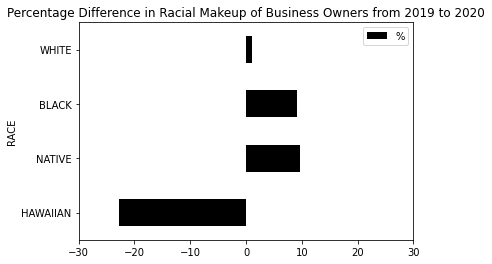

In [282]:
raceownedbus.plot(x = 'RACE', y = ['PERCENTAGE_DIFFERENCE'], kind = 'barh', title = 'Percentage Difference in Racial Makeup of Business Owners from 2019 to 2020', color = 'black', xticks = [-30, -20, -10, 0, 10, 20, 30], ylabel = 'Percentage Difference from 2019 to 2020').legend('%')